# **New or Used - Product Type**

## Exploratory Data Analysis Step
## Felipe Daiha Alves

# **Goal**

Report of the *Exploratory Data Analysis* second stage, containing informations about the process of **data analysis** phase. The main goal here is to determine the **most discriminating variables** in relation to the target *condition* (*new/used*). The information collected will serve as the basis for composing our future *Machine Learning* model.

# **Environment**

Initially, we will carry out the **preparation of the work environment**, so that the dataset is ready to be analyzed.

### **Importing Required Packages**

In [1]:
import logging
import sys
import os
from warnings import filterwarnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
from tabulate import tabulate
import string
from difflib import SequenceMatcher
from itertools import zip_longest

### **Functions**

##### 1 - logger_config

In [2]:
def logger_config():
    """
    Configurate logger format for monitoring steps in EDA pipeline.
    """
    # Var logger
    logger = logging.getLogger("Logger")
    logger.setLevel(logging.DEBUG)
    # Creating formatter
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # Console handler to set level and add formatter to handler
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    handler.setFormatter(formatter)
    # Adding handlers to feature 'logger'
    logger.addHandler(handler)
    # Returning log configuration
    return logger

##### 2 - totals_table

In [3]:
def totals_table(data: pd.DataFrame, target:str, grouped_var: str):
    """
    Create totals table to analyze proportion of each class over target.
    Also has informations about the count values of thar class and the
    total over the target.
    """
    try:
        # Creating dataframe to be used on plot
        # Count occurances per target-grouped_var
        totals_per_condition_group = data.groupby([target, grouped_var]).size().reset_index(name='count')
        # Count rows per target
        totals_per_condition = data.groupby([target]).size().reset_index(name='count')
        # Everything in the same df
        totals = totals_per_condition_group.merge(
            totals_per_condition, on=target, how="left",
            suffixes=('_group', '_condition'))
        # Counting percentage, based on the two count columns and
        # multiply the percentage values by 100.
        totals["percentage"] = totals["count_group"]/totals["count_condition"]
        totals['percentage'] = totals['percentage'] * 100
        # Sorting values by group
        totals = totals.sort_values(by=[grouped_var])
        # Execution success log
        log.info(
            "Succesfully create 'totals_table' for '%s' and '%s' comparasion!",
            target, grouped_var
        )
        # Returning results
        return totals
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create 'totals_table' for '%s' and '%s' comparasion!",
            target, grouped_var
        )

##### 3 - stacked_plots

In [4]:
def stacked_plots(data: pd.DataFrame, target: str, grouped_var: str):
    """
    Creating stacked percentage bar plots using
    MatPlotLib to evaluate percentage of boolean and
    binary columns over another column.
    """
    try:
        # Creating totals_table
        totals = totals_table(
            data=data,
            target=target,
            grouped_var=grouped_var
        )
        # Creating pivot table to aux plot
        # Pivot the dataframe to create a multi-index
        df_pivot = totals.pivot(index=target, columns=grouped_var, values='percentage')
        # Create the percent stacked barplot
        ax = df_pivot.plot(kind='bar', stacked=True)
        plt.title(f"Percent Stacked Barplot - {grouped_var}")
        plt.xlabel(target)
        plt.ylabel('Percentage (%)')
        plt.legend(title=grouped_var, bbox_to_anchor=(1.05, 1), loc='upper left')
        # Execution success log
        log.info(
            "Succesfully create the stacked percentage bar plot for '%s' and '%s' analysis!",
            target, grouped_var
        )
        # Returning table and plot
        return print(totals), plt.show()
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create stacked percentage bar plot for '%s' and '%s' analysis!",
            target, grouped_var
        )

##### 4 - boxplot_numericals

In [5]:
def boxplot_numericals(data: pd.DataFrame, target: str, grouped_var: str):
    """
    Boxplot view to analyze distribution over numerical features.
    """
    try:
        # Creating aux data and unique values
        boxplot_data = [data[data[target] == values][grouped_var] for values in data[target].unique()]
        # Create a boxplot using matplotlib and specify colors
        colors = ["blue", "yellow"]
        boxplot = plt.boxplot(
            boxplot_data,
            labels=data[target].unique(),
            patch_artist=True
        )
        # set the color of each boxplot
        for patch, color in zip(boxplot['boxes'], colors):
            patch.set_facecolor(color)
        # Add titles and labels
        plt.title(f'Boxplot - {grouped_var} by {target}')
        plt.xlabel(target)
        plt.ylabel(grouped_var)
        # Execution success log
        log.info(
            "Succesfully create the boxplot for '%s' and '%s' analysis!",
            target, grouped_var
        )
        # Display the plot
        return plt.show()
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create boxplot for '%s' and '%s' analysis!",
            target, grouped_var
        )

##### 5 - text_analysis

In [6]:
def text_analysis(text_df: pd.DataFrame, target: str, grouped_var: str, min_count: int, abs_diff: int):
    """
    Create dataframe to analyze proportion of each word in a text column
    grouped by a target column.
    """
    try:
        # Replacing NaN with string "blank" for counting without dropping NaN
        text_df[grouped_var] = np.where(text_df[grouped_var].isna(), 'blank', text_df[grouped_var])
        # Remove special characters from the column
        text_df[grouped_var] = text_df[grouped_var].str.replace('[^a-zA-Z0-9\s]', '')
        # Convert the column to lower case
        text_df[grouped_var] = text_df[grouped_var] .str.lower()
        # Group the words by target and count them
        word_counts = text_df.groupby(target)[grouped_var].apply(
            lambda x: pd.value_counts(x.str.split(expand=True).stack())).unstack(fill_value=0)
        # Transpose the dataframe and rename index
        word_counts = word_counts.T.rename_axis("index", axis=1)
        new_column_name = f"{grouped_var}_word"
        word_counts = word_counts.reset_index(names=new_column_name)
        # Calculating percentages
        word_counts["perc_new"] = (word_counts["new"]/(word_counts["new"] + word_counts["used"])) * 100
        word_counts["perc_used"] = (word_counts["used"]/(word_counts["new"] + word_counts["used"])) * 100
        # Some filters:
        # 1 - Filter rows if sum of 'new' & 'used' is less than 'min_count' and
        # absolute diff between 'perc_new' & 'perc_used' has to be greater than 'abs_diff'. 
        word_counts = word_counts.loc[(word_counts['new'] + word_counts['used']) > min_count]
        word_counts = word_counts.loc[(abs(word_counts['perc_new'] - word_counts['perc_used']) > abs_diff)]
        # 2 - List of prepositions, articles, pronouns in Spanish, letters and others texts
        prepositions = [
            'a', 'ante', 'bajo', 'cabe', 'con', 'contra', 'de',
            'desde', 'durante', 'en', 'entre', 'hacia', 'hasta', 'mediante', 'para', 'por',
            'según', 'sin', 'so', 'sobre', 'tras'
        ]
        articles = ['el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'lo']
        pronouns = [
            'yo', 'tú', 'él', 'ella', 'usted', 'nosotros', 'nosotras', 'vosotros', 'vosotras',
            'ellos', 'ellas', 'ustedes', 'mí', 'ti', 'sí', 'conmigo', 'contigo', 'consigo', 
            'mismo', 'misma', 'mismos', 'mismas', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 
            'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 
            'vuestra', 'vuestros', 'vuestras'
        ]
        letters = list(string.ascii_lowercase)
        others = [
            'ao', 'aos', 'del', 'no', 'mi', 'mis'
        ]
        word_counts = word_counts.loc[~word_counts[new_column_name].isin(
            prepositions + articles + pronouns + letters + others)]
        # Sorting dataframe in descending order on column "perc_new"
        word_counts = word_counts.sort_values(by=["perc_new"], ascending=False)
        # Execution success log
        log.info(
            "Dataframe for '%s' and '%s' text analysis succesfully done!",
            target, grouped_var
        )
        # Return dataframe result
        return word_counts
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create dataframe for '%s' and '%s' text analysis!",
            target, grouped_var
        )

##### 6 - horizontal_barplot

In [7]:
def horizontal_barplot(data: pd.DataFrame, top: int, x_axis: str, y_axis: str):
    """
    Plot ranking of top words that most discriminate product condition.
    """
    try:
        # Filter data by top 'n' values
        top_values = data.sort_values(by="perc_new", ascending=False).head(top)
        # Create the barplot
        plt.barh(
            top_values[y_axis],
            top_values[x_axis],
            color='blue'
        )
        # Add labels inside the bars
        for i, v in enumerate(top_values[x_axis]):
            plt.text(v + 0.3, i, str(round(v)) + '%', color='black', fontweight='bold')
        # Set the x-axis label
        plt.xlabel(f'{x_axis} (%)')
        # Set the title
        plt.title(f'{x_axis} by {y_axis} - Top {top}')
        # Execution success log
        log.info(
            "Horizontal barplot for '%s' and their '%s' values succesfully done!",
            y_axis, x_axis
        )
        # Show the plot
        return plt.show()
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create horizontal barplot for '%s' and their '%s' values!",
            y_axis, x_axis
        )

##### 7 - dummy_texts

In [8]:
def dummy_texts(data: pd.DataFrame, column: str, list_of_words: list):
    """
    Create new columns, based on if string in a list exists
    in a specific column defined.
    """
    try:
        # Copy the dataframe
        df_dummy_text = data.copy()
        # Replacing NaN with string "blank" for counting without dropping NaN
        df_dummy_text[column] = np.where(df_dummy_text[column].isna(), 'blank', df_dummy_text[column])
        # Removing special characters from the column
        df_dummy_text[column] = df_dummy_text[column].str.replace('[^a-zA-Z0-9\s]', '')
        # Convert the column to lower case
        df_dummy_text[column] = df_dummy_text[column] .str.lower()
        # Create a new column for each word in the list
        for word in list_of_words:
            df_dummy_text[f"has_{word}_in_{column}"] = df_dummy_text[column].str.contains(word).astype(int)
        # Execution success log
        log.info("Creating dummy vars from the following list '%s' succesfully done!", list_of_words)
        # Return the dataframe with the columns created
        return df_dummy_text
    except ImportError:
        # Execution error log
        log.error("Something went wrong... Could not create dummy vars from the following list '%s'!", list_of_words)

##### 8 - similarity_sequence_list_df

In [9]:
def similarity_sequence_list_df(list_of_words: list, percent: float, data: pd.DataFrame, column: str):
    """
    Check string similarity using SequenceMatcher.
    Drop one of the values in the list_of_words and
    replace by the similar word.
    """
    try:
        # Create a copy of the 'data' and the 'list_of_words'
        data_copy = data.copy()
        list_copy = list_of_words.copy()
        # Create a list of tuples containing the word pairs and their similarity values
        similarity_list = [(
            word1 + ', ' + word2, SequenceMatcher(None, word1, word2).ratio())
            for i, word1 in enumerate(list_copy)
            for j, word2 in enumerate(list_copy)
            if i != j and i < j
        ]
        # Sort the word pairs alphabetically and convert to a set to remove duplicates
        similarity_set = set(tuple(sorted(pair.split(', '))) + (similarity,) for pair, similarity in similarity_list)
        # Create the dataframe from the similarity list and filter only when similarity is greater than 'percent'
        df_similarities = pd.DataFrame(similarity_list, columns=["word_pair", "similarity"]).query(f"similarity >= {percent}")
        # Get the first word before comma in "word_pair" column
        df_similarities["first_word"] = df_similarities["word_pair"].str.split(',').str[0]
        # Loop through the rows of "df_similarities" to replace the words in "data"
        for index, row in df_similarities.iterrows():
            data_copy[column] = data_copy[column].str.replace(
                r'\b' + row["first_word"] + r'\b', row["word_pair"].split(', ')[1], regex=True
            )
        # Remove the first_word values from the list_copy
        list_copy = [word for word in list_of_words if word not in df_similarities["first_word"].tolist()]
        # Execution success log
        log.info(
            "New list without words with higher similarities and \
handle them into '%s' column succesfully done!",
            column
        )
        # Returning dataframe and list as results
        return list_copy, data_copy
    except ImportError:
        # Execution error log
        log.error(
            "Something went wrong... Could not create the ew list without words with higher similarities and \
handle them into '%s' column!",
            column
        )

### **Settings**

##### Config options

In [10]:
# Declare logger default
log = logger_config()

# Filtering to suppress warnings
filterwarnings("ignore")

# Display pandas formats
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Dimensions of the plots
plt.rcParams['figure.figsize'] = [10, 6]

##### Loading parquet file as pandas dataframe

In [11]:
try:
    # Importing parquet file
    eda_new_or_used = pq.read_table(
        os.path.join(os.getcwd(), 'outputs', "eda_new_or_used.parquet"),
    )
    # Convert the PyArrow table to a Pandas DataFrame
    eda_new_or_used = eda_new_or_used.to_pandas()
    # Execution success log
    log.info("Read parquet file as a pandas dataframe succesfully done!")
except ImportError:
    # Execution error log
    log.error("Something went wrong... Could not read parquet file as a pandas dataframe!")

2023-02-28 12:42:27,673 - Logger - INFO - Read parquet file as a pandas dataframe succesfully done!


##### Remembering our dataframe structure

In [12]:
# Showing some rows of the dataframe previously saved
eda_new_or_used.head(5)

,id,seller_id,parent_item_id,category_id,currency_id,video_id,official_store_id,date_mon_day_interval,thumbnail,secure_thumbnail,accepts_mercadopago,automatic_relist,warranty,title,buying_mode,status,listing_type_id,initial_quantity,condition,seller_address_country.id,seller_address_state.id,seller_address_city.id,shipping_local_pick_up,shipping_free_shipping,shipping_mode,tags_count_dragged_bids_and_visits,tags_count_dragged_visits,tags_count_free_relist,tags_count_good_quality_thumbnail,tags_count_poor_quality_thumbnail,non_mercado_pago_payment_methods_id_count,variations_id_count,attributes_id_count,pictures_id_count
0,MLA5569012823,6309630046,MLA3553408060,MLA4761,ARS,None,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/594501-MLA5569012...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,None,Mesa Artesanal - Diseño Exclusivo,buy_it_now,active,bronze,1,new,AR,AR-B,TUxBQ0xBUGxhdGE,True,False,me2,1,0,0,0,0,2,0,0,3
1,MLA4321590423,2302325100,MLA2552875301,MLA41104,ARS,None,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/13520-MLA43215904...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,Sí,Marlon Brando En Queimada / Revista La Nacion ...,buy_it_now,active,free,1,used,AR,AR-C,,True,False,not_specified,1,0,0,0,0,3,0,0,1
2,MLA5627466779,8179118524,MLA1557421790,MLA1963,ARS,None,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/4073-MLA562746677...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sin garantía,Revista Monde Médical - Junio 1939 - Num 934,buy_it_now,active,free,1,used,AR,AR-B,,True,False,not_specified,1,0,0,0,0,2,0,0,4
3,MLA8199445927,5597288044,MLA6681207150,MLA6009,ARS,None,NaN,2015-08-2,http://mla-s2-p.mlstatic.com/6279-MLA819944592...,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,True,False,Sí,Sociedades Y Hombres Caryl P...,buy_it_now,active,bronze,1,used,AR,AR-C,TUxBQlJFVDgyMDVa,False,False,me2,1,0,0,0,0,1,0,0,1
4,MLA4202324909,5976171738,MLA1065169171,MLA15171,ARS,None,NaN,2015-08-2,http://mla-s1-p.mlstatic.com/10618-MLA42023249...,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,True,False,None,Ministry - Twitch Cd,buy_it_now,active,free,1,used,AR,AR-B,,False,False,custom,1,0,0,0,0,1,0,0,1


# **Data Analysis**

For our data analysis process, each view will be explained from an **a priori hypothesis**, which will justify its use (or not) as a feature for our **future model**.

### **Booleans and Binary Classes**

##### 1 - warranty

**Hypothesis**: New products usually have a warranty offer.

2023-02-28 12:42:27,872 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_warranty' comparasion!
2023-02-28 12:42:27,936 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_warranty' analysis!


  condition  has_warranty  count_group  count_condition  percentage
0       new             0        28936            52885       54.71
2      used             0        30759            45437       67.70
1       new             1        23949            52885       45.29
3      used             1        14678            45437       32.30


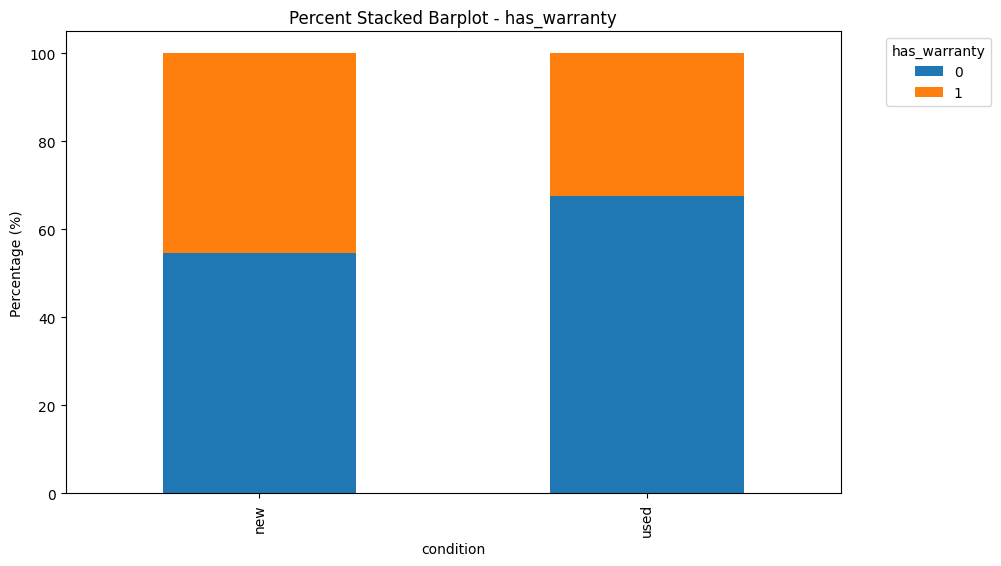

In [13]:
# Creating subset
bool_warranty = eda_new_or_used.loc[:, ["condition", "warranty"]]

# Replacing NaN values with 0, else 1
bool_warranty["has_warranty"] = np.where(bool_warranty["warranty"].isna(), 0, 1)
bool_warranty = bool_warranty.drop("warranty", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_warranty,
    target="condition",
    grouped_var="has_warranty"
)

# Drop temp df
del bool_warranty

**Comments**: The information is **NOT SO EVIDENT**, but there is some discrimination in relation to the *condition* of the product.

##### 2 - shipping_local_pick_up

**Hypothesis**: Sellers with new products **can offer** local pick up, instead of sellers with used products, normally people without a store or something like that.

2023-02-28 12:42:28,137 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'shipping_local_pick_up' comparasion!
2023-02-28 12:42:28,175 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'shipping_local_pick_up' analysis!


  condition  shipping_local_pick_up  count_group  count_condition  percentage
0       new                   False        10581            52885       20.01
2      used                   False         9106            45437       20.04
1       new                    True        42304            52885       79.99
3      used                    True        36331            45437       79.96


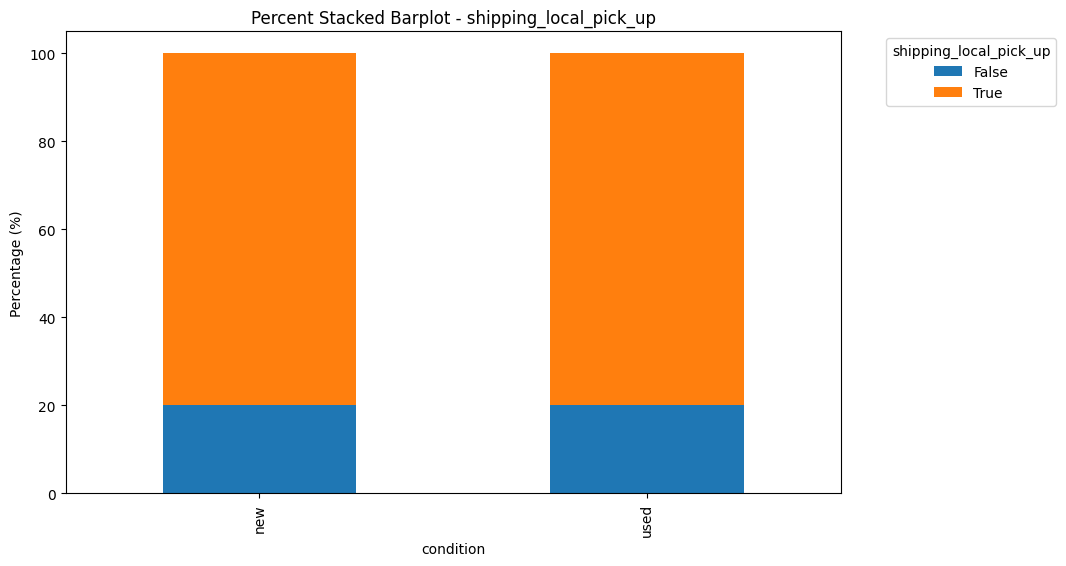

In [14]:
# Creating subset
bool_local_pick_up = eda_new_or_used.loc[:, ["condition", "shipping_local_pick_up"]]

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_local_pick_up,
    target="condition",
    grouped_var="shipping_local_pick_up"
)

# Drop temp df
del bool_local_pick_up

**Comments**: The feature **does not** give us the expected discrimination force.

##### 3 - shipping_free_shipping

**Hypothesis**: Very active sellers in the marketplace (usually selling new products) know that offering products with free shipping increases product exposure.

2023-02-28 12:42:28,396 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'shipping_free_shipping' comparasion!
2023-02-28 12:42:28,470 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'shipping_free_shipping' analysis!


  condition  shipping_free_shipping  count_group  count_condition  percentage
0       new                   False        51311            52885       97.02
2      used                   False        44055            45437       96.96
1       new                    True         1574            52885        2.98
3      used                    True         1382            45437        3.04


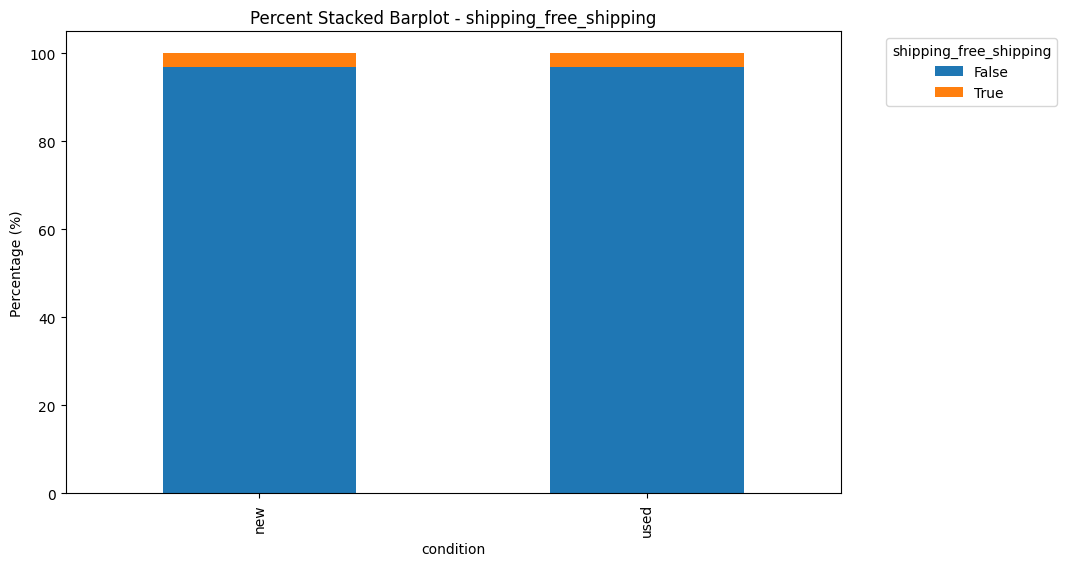

In [15]:
# Creating subset
bool_free_shipping = eda_new_or_used.loc[:, ["condition", "shipping_free_shipping"]]

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_free_shipping,
    target="condition",
    grouped_var="shipping_free_shipping"
)

# Drop temp df
del bool_free_shipping

**Comments**: When group by the target, basically has the **same proportion** for each class.

##### 4 - variations_id_count

**Hypothesis**: If it presents a variety of types of the same product, it MUST BE a new one. It's unusual a seller has variety of the **same used product**.

2023-02-28 12:42:28,905 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_variations' comparasion!
2023-02-28 12:42:28,999 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_variations' analysis!


  condition  has_variations  count_group  count_condition  percentage
0       new               0        48236            52885       91.21
2      used               0        42000            45437       92.44
1       new               1         4649            52885        8.79
3      used               1         3437            45437        7.56


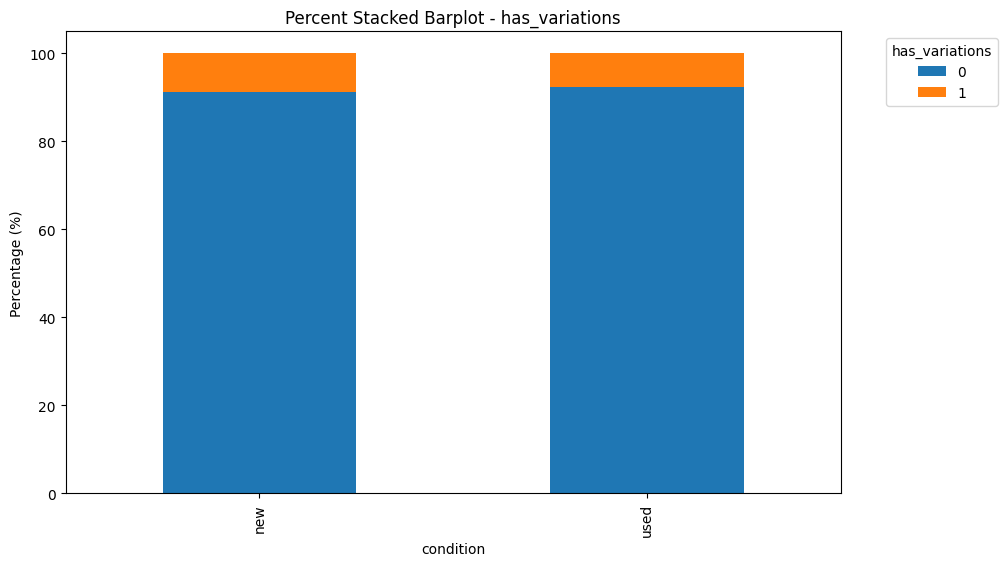

In [16]:
# Creating subset
bool_variations = eda_new_or_used.loc[:, ["condition", "variations_id_count"]]

# Replacing >1 values with 1, else 0
bool_variations["has_variations"] = np.where(bool_variations["variations_id_count"] == 0, 0, 1)
bool_variations = bool_variations.drop("variations_id_count", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_variations,
    target="condition",
    grouped_var="has_variations"
)

# Drop temp df
del bool_variations

**Comments**: The variable in binary format **does not** discriminate the *condition* of the product at all.

##### 5 - attributes_id_count

**Hypothesis**: If product attributes were described, the seller is aware of the **technical data sheet** and it must be a **new** product.

2023-02-28 12:42:29,434 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_attributes' comparasion!
2023-02-28 12:42:29,530 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_attributes' analysis!


  condition  has_attributes  count_group  count_condition  percentage
0       new               0        45763            52885       86.53
2      used               0        40831            45437       89.86
1       new               1         7122            52885       13.47
3      used               1         4606            45437       10.14


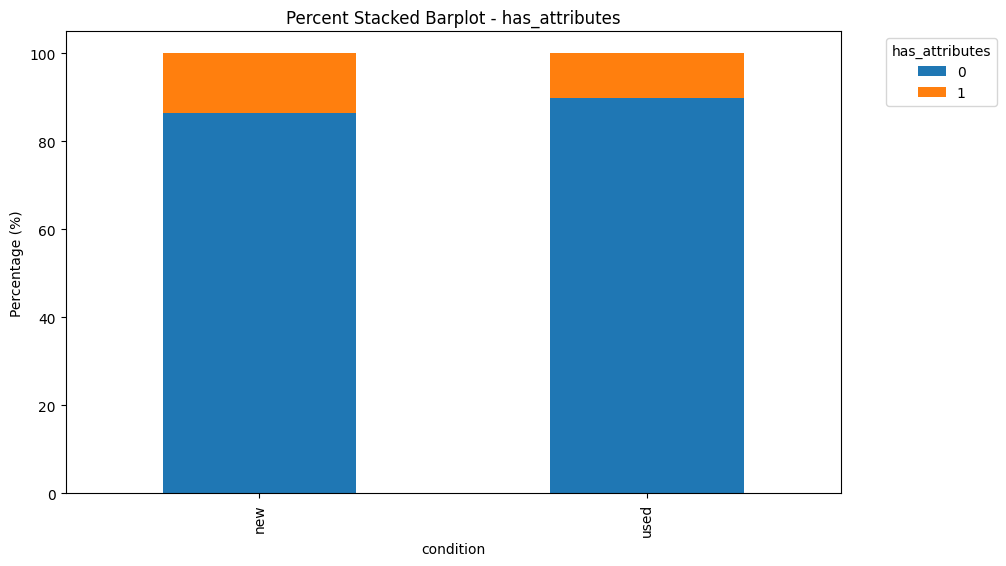

In [17]:
# Creating subset
bool_attributes = eda_new_or_used.loc[:, ["condition", "attributes_id_count"]]

# Replacing >1 values with 1, else 0
bool_attributes["has_attributes"] = np.where(bool_attributes["attributes_id_count"] == 0, 0, 1)
bool_attributes = bool_attributes.drop("attributes_id_count", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_attributes,
    target="condition",
    grouped_var="has_attributes"
)

# Drop temp df
del bool_attributes

**Comments**: The feature in binary format **does not** discriminate the *condition* of the product at all either.

##### 6 - automatic_relist

**PS**: I don't know exactly what this variable means, but it seems to be a flag to enable when the product runs out of stock, **automatically relisting the product on the marketplace**. I will start from this premise.

**Hypothesis**: If this is set to True, the seller of a new product wants to make it clear to the consumer that **he sells that product**, even if it is currently out of stock, taking steps to obtain new quantities.

2023-02-28 12:42:29,934 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'automatic_relist' comparasion!
2023-02-28 12:42:30,088 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'automatic_relist' analysis!


  condition  automatic_relist  count_group  count_condition  percentage
0       new             False        48456            52885       91.63
2      used             False        45222            45437       99.53
1       new              True         4429            52885        8.37
3      used              True          215            45437        0.47


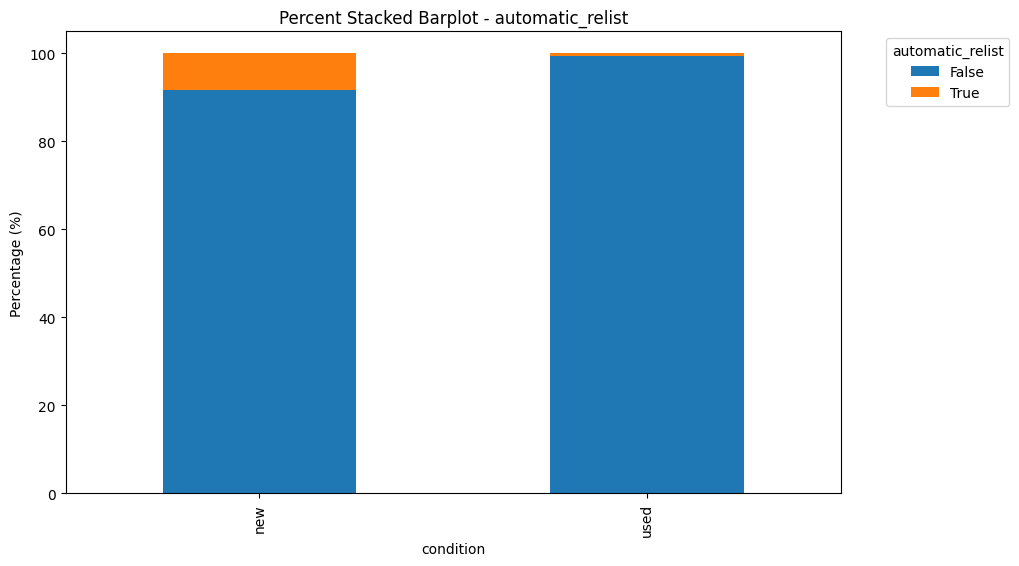

In [18]:
# Creating subset
bool_relist = eda_new_or_used.loc[:, ["condition", "automatic_relist"]]

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_relist,
    target="condition",
    grouped_var="automatic_relist"
)

# Drop temp df
del bool_relist

**Comments**: Used products, since they are produced in small quantities (1, 2 generally), are practically **not relisted** on the marketplace.

For new products, some sellers **enable this feature**. A new binary feature can be created if automatic_relist is set to True equal to 1, else 0.

##### 7 - video_id

**Hypothesis**: The seller of a new product usually makes a **qualified description** of the product, exposing photos and videos.

2023-02-28 12:42:30,495 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_video' comparasion!
2023-02-28 12:42:30,567 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_video' analysis!


  condition  has_video  count_group  count_condition  percentage
0       new          0        50653            52885       95.78
2      used          0        44781            45437       98.56
1       new          1         2232            52885        4.22
3      used          1          656            45437        1.44


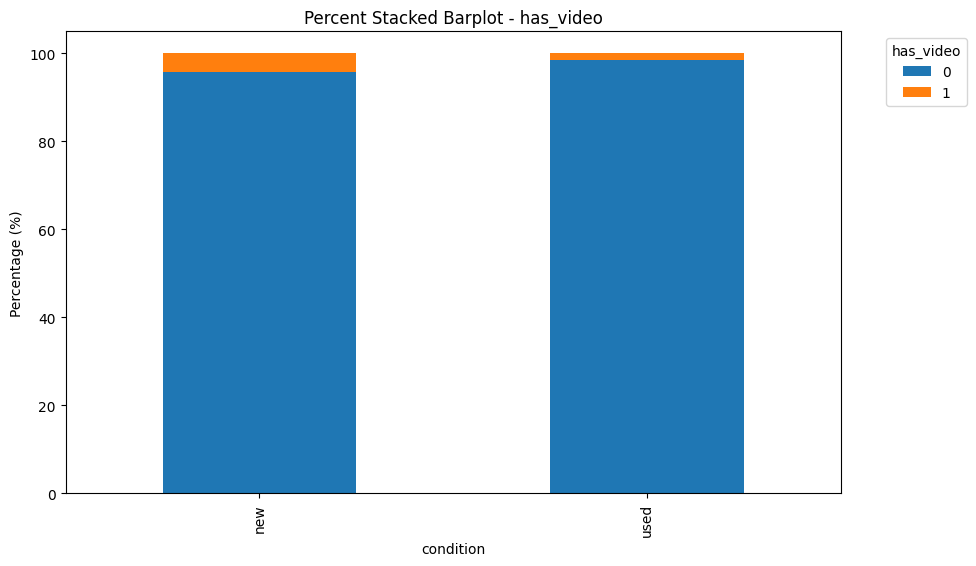

In [19]:
# Creating subset
bool_video = eda_new_or_used.loc[:, ["condition", "video_id"]]

# Replacing NaN values with 0, else 1
bool_video["has_video"] = np.where(bool_video["video_id"].isna(), 0, 1)
bool_video = bool_video.drop("video_id", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_video,
    target="condition",
    grouped_var="has_video"
)

# Drop temp df
del bool_video

**Comments**: Uploading a video **does not** show significant discrimination in relation to *condition*.

##### 8 - official_store_id

**Hypothesis**: If the seller has an official store, it is possibly that he sells **new products**.

2023-02-28 12:42:30,777 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_official_store' comparasion!
2023-02-28 12:42:30,812 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_official_store' analysis!


  condition  has_official_store  count_group  count_condition  percentage
0       new                   0        52096            52885       98.51
2      used                   0        45415            45437       99.95
1       new                   1          789            52885        1.49
3      used                   1           22            45437        0.05


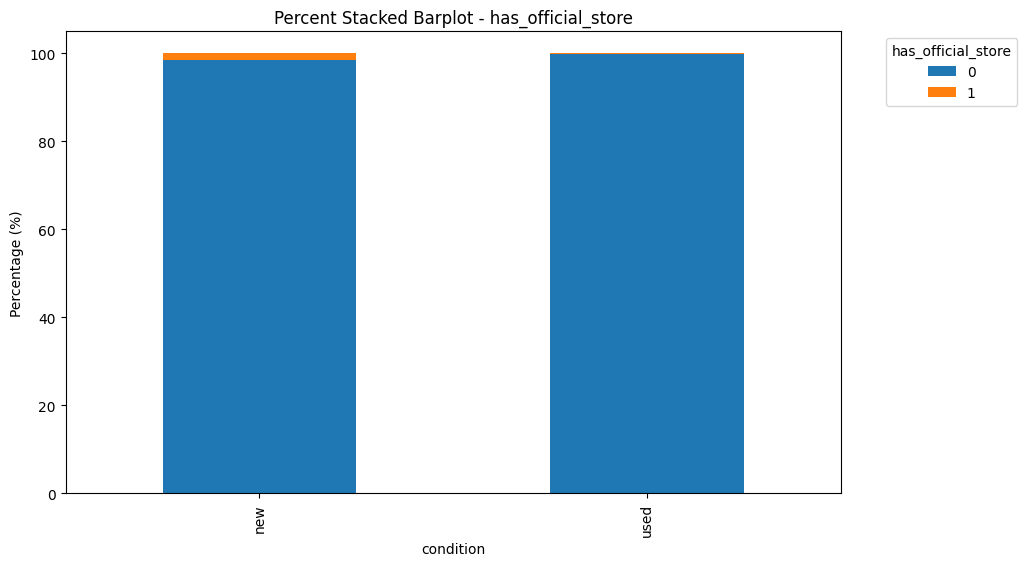

In [20]:
# Creating subset
bool_official_store = eda_new_or_used.loc[:, ["condition", "official_store_id"]]

# Replacing NaN values with 0, else 1
bool_official_store["has_official_store"] = np.where(bool_official_store["official_store_id"].isna(), 0, 1)
bool_official_store = bool_official_store.drop("official_store_id", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=bool_official_store,
    target="condition",
    grouped_var="has_official_store"
)

# Drop temp df
del bool_official_store

**Comments**: **Strongly discriminates** when equal to *True* (1). However, the low number of records will hardly make the model capture this information. It will be binarized and tested in the model.

### **Multi-Class & Integers Features**

##### 1 - non_mercado_pago_payment_methods_id_count

**Hypothesis**: New products offer **greater variety** of payment methods.

2023-02-28 12:42:31,049 - Logger - INFO - Succesfully create the boxplot for 'condition' and 'non_mercado_pago_payment_methods_id_count' analysis!


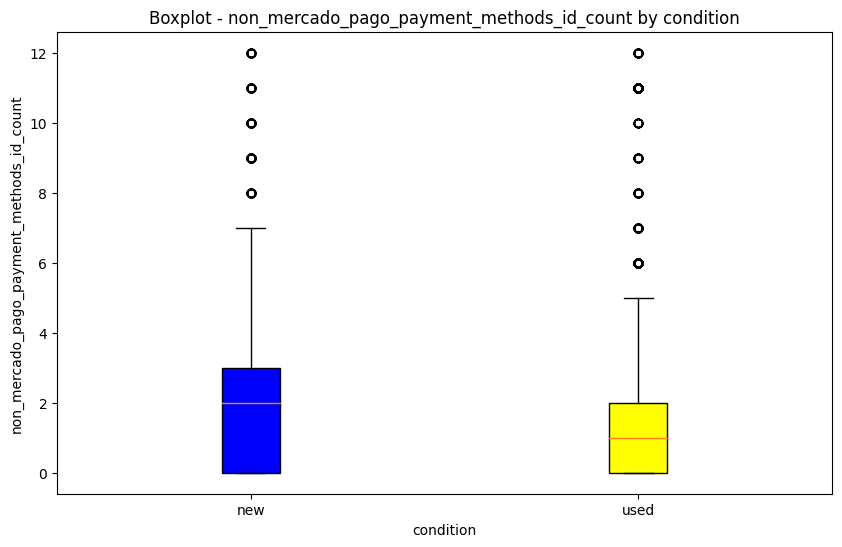

In [21]:
# Create subset
multi_payment_methods = eda_new_or_used.loc[:, ["condition", "non_mercado_pago_payment_methods_id_count"]]

# Check distribution in a boxplot
boxplot_numericals(
    multi_payment_methods,
    target="condition",
    grouped_var="non_mercado_pago_payment_methods_id_count"
)

**Comments**: We have more differentiation when the number of payments is **greater than 2**. Let's turn it into a binary variable and check the new proportion.

2023-02-28 12:42:31,269 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_more_than_2_payment_methods' comparasion!
2023-02-28 12:42:31,312 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_more_than_2_payment_methods' analysis!


  condition  has_more_than_2_payment_methods  count_group  count_condition  \
0       new                                0        34552            52885   
2      used                                0        36070            45437   
1       new                                1        18333            52885   
3      used                                1         9367            45437   

   percentage  
0       65.33  
2       79.38  
1       34.67  
3       20.62  


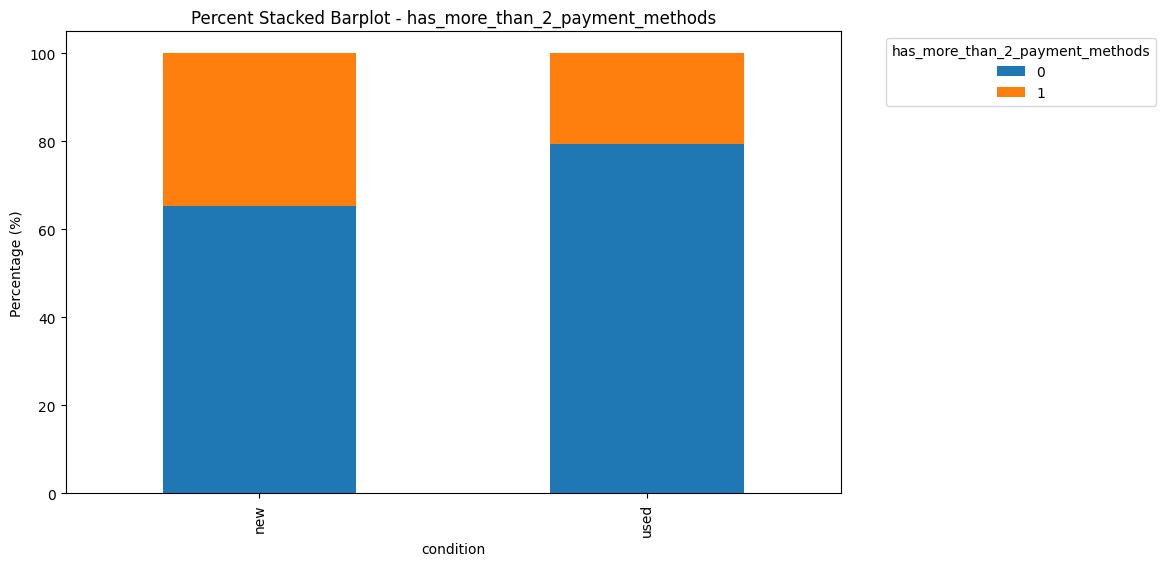

In [22]:
# Extract quantile when condition == new
quantile_new_pm = multi_payment_methods.loc[
    multi_payment_methods["condition"] == 'new'
]["non_mercado_pago_payment_methods_id_count"].quantile(0.5).astype(int)

# New column name
col_name = f"has_more_than_{quantile_new_pm}_payment_methods"

# Replacing over quantile values by 1, else 0
multi_payment_methods[col_name] = np.where(
    multi_payment_methods["non_mercado_pago_payment_methods_id_count"] > quantile_new_pm, 1, 0)
multi_payment_methods = multi_payment_methods.drop("non_mercado_pago_payment_methods_id_count", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=multi_payment_methods,
    target="condition",
    grouped_var=col_name
)

# Drop temp df
del multi_payment_methods, quantile_new_pm, col_name

**Comments**: The differentiation in relation to the target is **more evident** when we binarize the variable.

##### 2 - listing_type_id

**Hypothesis**: The listing_type is better qualified on new products than on used.

In [23]:
# Create subset
multi_listing_type = eda_new_or_used.loc[:, ["condition", "listing_type_id"]]

# Creating 'totals_table' format view
table_listing_type = totals_table(
    data=multi_listing_type,
    target="condition",
    grouped_var="listing_type_id"
)

# Fancy printing results 
print(tabulate(table_listing_type, headers='keys', tablefmt="double_grid"))

# Drop temp tbl
del multi_listing_type, table_listing_type

2023-02-28 12:42:31,577 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'listing_type_id' comparasion!


╔════╦═════════════╦═══════════════════╦═══════════════╦═══════════════════╦══════════════╗
║    ║ condition   ║ listing_type_id   ║   count_group ║   count_condition ║   percentage ║
╠════╬═════════════╬═══════════════════╬═══════════════╬═══════════════════╬══════════════╣
║  0 ║ new         ║ bronze            ║         38957 ║             52885 ║   73.6636    ║
╠════╬═════════════╬═══════════════════╬═══════════════╬═══════════════════╬══════════════╣
║  7 ║ used        ║ bronze            ║         23555 ║             45437 ║   51.841     ║
╠════╬═════════════╬═══════════════════╬═══════════════╬═══════════════════╬══════════════╣
║  1 ║ new         ║ free              ║          1573 ║             52885 ║    2.97438   ║
╠════╬═════════════╬═══════════════════╬═══════════════╬═══════════════════╬══════════════╣
║  8 ║ used        ║ free              ║         19649 ║             45437 ║   43.2445    ║
╠════╬═════════════╬═══════════════════╬═══════════════╬═══════════════════╬════

**Comments**: The results expose the **truth of the hypothesis**. New products present **better listings** in relation to used products, in which most sellers of used products leave the listing as *free*, while sellers of new products prefer listings that allow **greater exposure** of their products, even if they have that provide the commission rate to the marketplace.

In a future moment, this feature can be transformed using *One-Hot-Encoding*, but the future columns with the values *gold_premium* and *gold_pro* will be removed due to the **low volume** of data or for not showing **proportions** for discrimination.

##### 3 - pictures_id_count

**Hypothesis**: Used products usually have **fewer pictures**. Professional sellers (usually new products) know the importance of the **number of photos for buyer security**.

2023-02-28 12:42:31,711 - Logger - INFO - Succesfully create the boxplot for 'condition' and 'pictures_id_count' analysis!


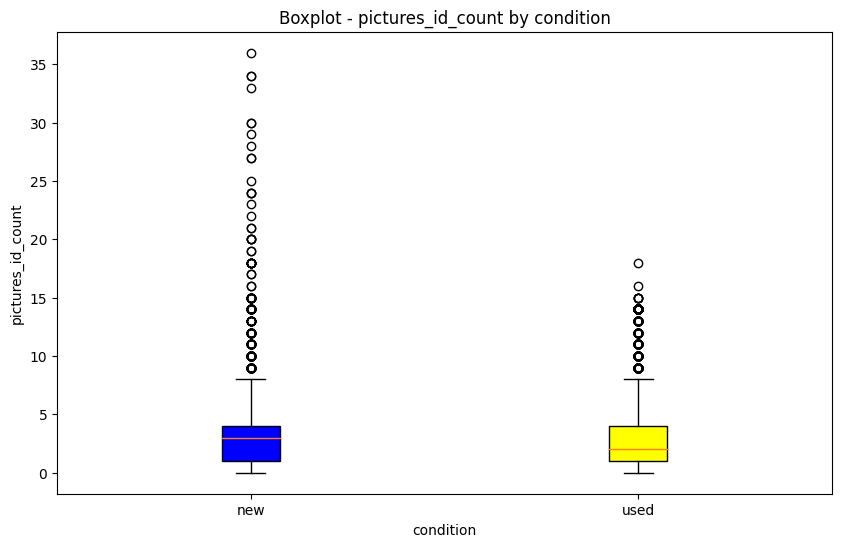

In [24]:
# Create subset
multi_pictures = eda_new_or_used.loc[:, ["condition", "pictures_id_count"]]

# Check distribution in a boxplot
boxplot_numericals(
    multi_pictures,
    target="condition",
    grouped_var="pictures_id_count"
)

**Comments**: The median number of photos for new products is **slightly higher** than for used products. Let's binarize and check the proportion according to this threshold.

2023-02-28 12:42:31,937 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_more_than_3_pictures' comparasion!
2023-02-28 12:42:31,977 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_more_than_3_pictures' analysis!


  condition  has_more_than_3_pictures  count_group  count_condition  \
0       new                         0        34435            52885   
2      used                         0        31525            45437   
1       new                         1        18450            52885   
3      used                         1        13912            45437   

   percentage  
0       65.11  
2       69.38  
1       34.89  
3       30.62  


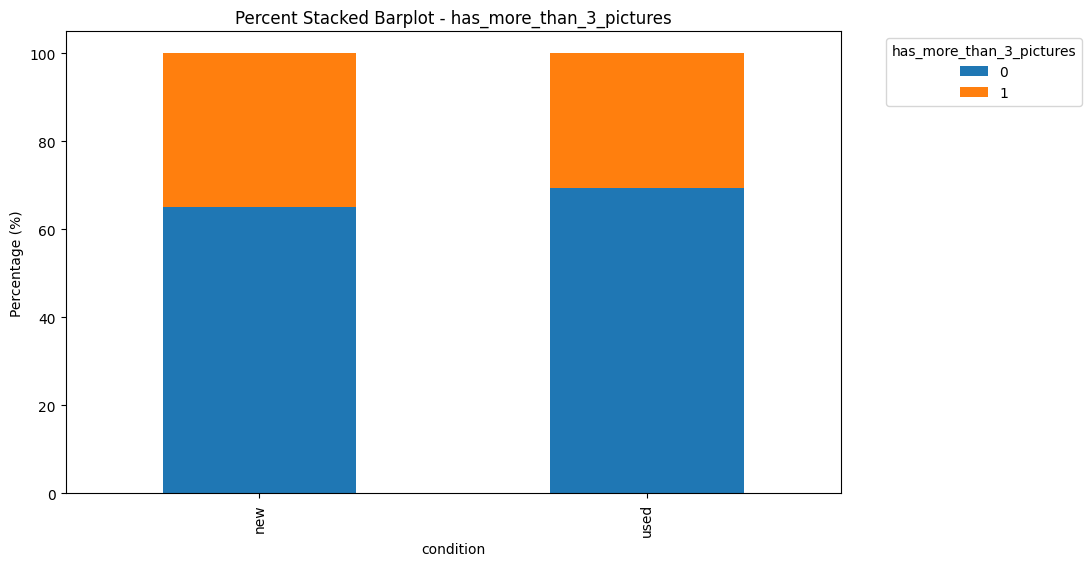

In [25]:
# Extract quantile 50% when condition == new
quantile_new_pic = multi_pictures.loc[
    multi_pictures["condition"] == 'new'
]["pictures_id_count"].quantile(0.5).astype(int)

# New column name
col_name = f"has_more_than_{quantile_new_pic}_pictures"

# Replacing over quantile values by 1, else 0
multi_pictures[col_name] = np.where(
    multi_pictures["pictures_id_count"] > quantile_new_pic, 1, 0)
multi_pictures = multi_pictures.drop("pictures_id_count", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=multi_pictures,
    target="condition",
    grouped_var=col_name
)

# Drop temp df
del multi_pictures, quantile_new_pic, col_name

**Comments**: Comparing the variable in binary format **does not** bring up relevant information.

##### 4 - initial_quantity

**Hypothesis**: Used product normally has **no more than 1** quantity to be sold.

2023-02-28 12:42:32,228 - Logger - INFO - Succesfully create the boxplot for 'condition' and 'new_initial_quantity' analysis!


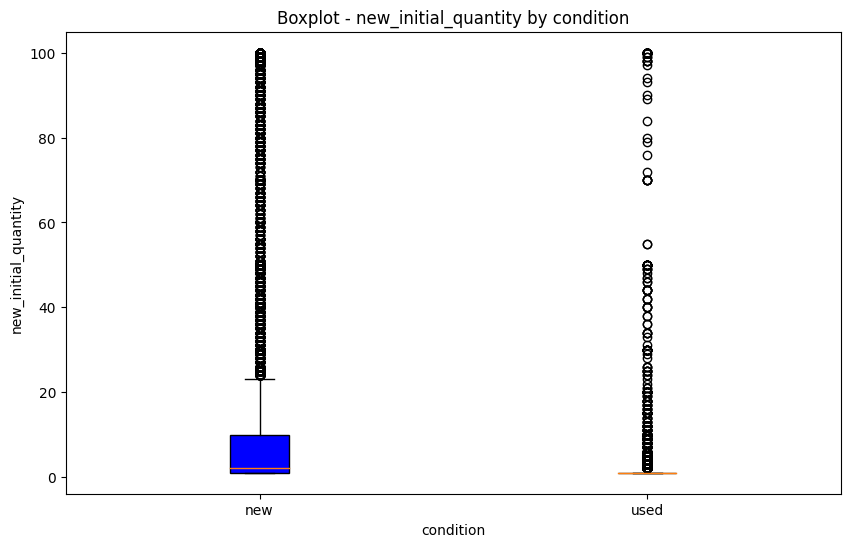

In [26]:
# Create subset
multi_init_quant = eda_new_or_used.loc[:, ["condition", "initial_quantity"]]

# Replacing over 100 values by 100, else keep same value
multi_init_quant["new_initial_quantity"] = np.where(
    multi_init_quant["initial_quantity"] > 100, 100, multi_init_quant["initial_quantity"])
multi_init_quant = multi_init_quant.drop("initial_quantity", axis=1)

# Check distribution in a boxplot
boxplot_numericals(
    multi_init_quant,
    target="condition",
    grouped_var="new_initial_quantity"
)

**Comments**: Indeed, new products seem to have **more units available** than old products. Let's binarize by setting the threshold to **1** to see the proportion.

2023-02-28 12:42:32,426 - Logger - INFO - Succesfully create 'totals_table' for 'condition' and 'has_more_than_1_initial_quantity' comparasion!
2023-02-28 12:42:32,466 - Logger - INFO - Succesfully create the stacked percentage bar plot for 'condition' and 'has_more_than_1_initial_quantity' analysis!


  condition  has_more_than_1_initial_quantity  count_group  count_condition  \
0       new                                 0        24989            52885   
2      used                                 0        43983            45437   
1       new                                 1        27896            52885   
3      used                                 1         1454            45437   

   percentage  
0       47.25  
2       96.80  
1       52.75  
3        3.20  


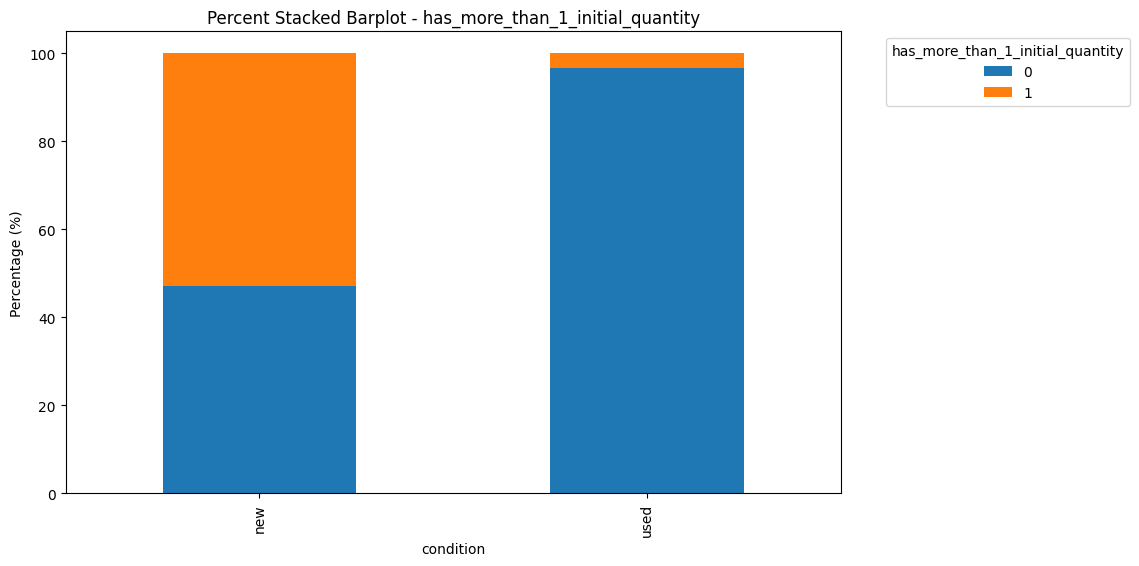

In [27]:
# Replacing values over 1 by 1, else 0
multi_init_quant["has_more_than_1_initial_quantity"] = np.where(
    multi_init_quant["new_initial_quantity"] > 1, 1, 0)
multi_init_quant = multi_init_quant.drop("new_initial_quantity", axis=1)

# Plot stacked percentage bar plot
stacked_plots(
    data=multi_init_quant,
    target="condition",
    grouped_var="has_more_than_1_initial_quantity"
)

# Drop temp df
del multi_init_quant

**Comments**: The **most representative** feature until now. The hypothesis is confirmed.

### **Text Features**

##### 1 - warranty

**Hypothesis**: Time strings like "meses", "años"; texts like "garantia", "falla" and numbers like 3, 6 and 1 should be associated with **new products**.

2023-02-28 12:42:33,625 - Logger - INFO - Dataframe for 'condition' and 'warranty' text analysis succesfully done!
2023-02-28 12:42:33,673 - Logger - INFO - Horizontal barplot for 'warranty_word' and their 'perc_new' values succesfully done!


╔══════╦═════════════════╦═══════╦════════╦════════════╦═════════════╗
║      ║ warranty_word   ║   new ║   used ║   perc_new ║   perc_used ║
╠══════╬═════════════════╬═══════╬════════╬════════════╬═════════════╣
║ 2688 ║ fabricacion     ║   920 ║      5 ║    99.4595 ║    0.540541 ║
╠══════╬═════════════════╬═══════╬════════╬════════════╬═════════════╣
║ 2682 ║ fabricacin      ║  1103 ║      9 ║    99.1906 ║    0.809353 ║
╠══════╬═════════════════╬═══════╬════════╬════════════╬═════════════╣
║ 4445 ║ oficial         ║  1218 ║     12 ║    99.0244 ║    0.97561  ║
╠══════╬═════════════════╬═══════╬════════╬════════════╬═════════════╣
║ 2706 ║ fabricante      ║   847 ║     10 ║    98.8331 ║    1.16686  ║
╠══════╬═════════════════╬═══════╬════════╬════════════╬═════════════╣
║ 2677 ║ fabrica         ║  1099 ║     17 ║    98.4767 ║    1.5233   ║
╠══════╬═════════════════╬═══════╬════════╬════════════╬═════════════╣
║  215 ║ 6               ║  2787 ║     57 ║    97.9958 ║    2.00422  ║
╠═════

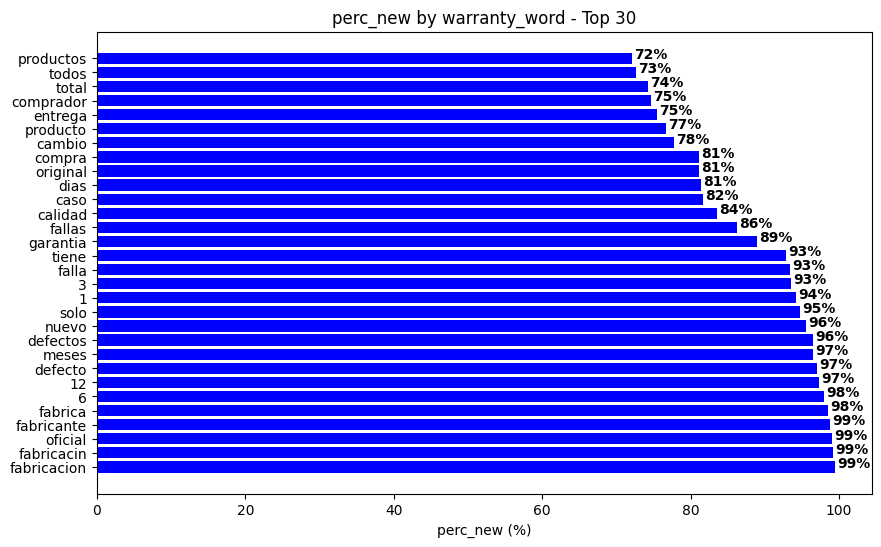

In [28]:
# Create a subset of the dataframe 
text_warranty = eda_new_or_used.loc[:, ["condition", "warranty"]]

# Min number of occurances and diff between proportions over target
min_n = round(len(eda_new_or_used) * 0.005)
diff = 40

# Call built function to create dataframe
text_warranty = text_analysis(
    text_df=text_warranty,
    target="condition",
    grouped_var="warranty",
    min_count=min_n,
    abs_diff=diff
)

# Fancy printing dataframe results 
print(tabulate(text_warranty, headers='keys', tablefmt="double_grid"))

# Create horizontal plot for better view
horizontal_barplot(
    data=text_warranty,
    top=30,
    x_axis="perc_new",
    y_axis="warranty_word"
)

**Comments**: The hypothesis is **confirmed** when the percentage difference between new and used is **above 40%** and considering words that appears at least **0.5%** in the dataset.

##### 2 - title

**Hypothesis**: Some sellers announce the condition of the product **on the title**; Others create **kits** of new products to provide a better option for customers; etc.

2023-02-28 12:42:35,980 - Logger - INFO - Dataframe for 'condition' and 'title' text analysis succesfully done!
2023-02-28 12:42:36,073 - Logger - INFO - Horizontal barplot for 'title_word' and their 'perc_new' values succesfully done!


╔═══════╦══════════════╦═══════╦════════╦════════════╦═════════════╗
║       ║ title_word   ║   new ║   used ║   perc_new ║   perc_used ║
╠═══════╬══════════════╬═══════╬════════╬════════════╬═════════════╣
║ 13192 ║ amortiguador ║   692 ║      0 ║  100       ║    0        ║
╠═══════╬══════════════╬═══════╬════════╬════════════╬═════════════╣
║ 30914 ║ delantero    ║   732 ║      7 ║   99.0528  ║    0.947226 ║
╠═══════╬══════════════╬═══════╬════════╬════════════╬═════════════╣
║ 40549 ║ freno        ║   598 ║      8 ║   98.6799  ║    1.32013  ║
╠═══════╬══════════════╬═══════╬════════╬════════════╬═════════════╣
║ 84990 ║ trasero      ║   741 ║     10 ║   98.6684  ║    1.33156  ║
╠═══════╬══════════════╬═══════╬════════╬════════════╬═════════════╣
║ 51095 ║ kit          ║  1325 ║     34 ║   97.4982  ║    2.50184  ║
╠═══════╬══════════════╬═══════╬════════╬════════════╬═════════════╣
║ 17483 ║ bateria      ║   546 ║     60 ║   90.099   ║    9.90099  ║
╠═══════╬══════════════╬═══════╬══

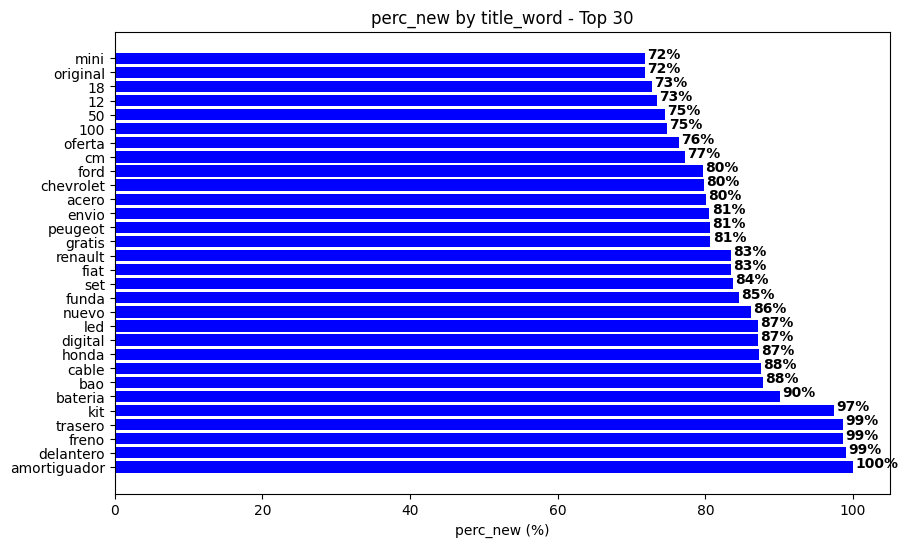

In [29]:
# Create a subset of the dataframe 
text_title = eda_new_or_used.loc[:, ["condition", "title"]]

# Call built function to create dataframe
text_title = text_analysis(
    text_df=text_title,
    target="condition",
    grouped_var="title",
    min_count=min_n,
    abs_diff=diff
)

# Fancy printing dataframe results 
print(tabulate(text_title, headers='keys', tablefmt="double_grid"))

# Create horizontal plot for better view
horizontal_barplot(
    data=text_title,
    top=30,
    x_axis="perc_new",
    y_axis="title_word"
)

# Drop temp vars
del min_n, diff

**Comments**: Although hypothesized to be validated under the same condition of percentage difference and minimun number of records, some products are **clearly trending to be new ones**, such as *kit*, *nuevo* or *original*.

### **Dataframe for ML**

Based on our analysis, we will perform a new data processing, now oriented towards the **Machine Learning** stage.

In [30]:
# Create a copy for the eda dataset
ml_new_or_used = eda_new_or_used.copy()

These are the following **feature engineering** that will be applied:

- *warranty*: Binary and Dummy Variables. If a product **has or not warranty** and if the warranty **has or not specific word**;
- *automatic_relist*: Binary. If seller **enable or not** automatic_relist feature for the product;
- *non_mercado_pago_payment_methods_id_count*: Binary. If the product accepts **more than 2** payment methods that not include mercado pago or not;
- *listing_type_id*: Dummy Variable. Each value will be split as a **binary column, containing or not** that specific value;
- *initial_quantity*: Binary. If product **has or not more than 1** quantity declared while creating the ad;
- *title*: Dummy Variables. If the title **has or not specific word**;
- *official_store_id*: Binary. If the seller of the product **has or not official store**.

**PS: THIS IS NOT THE MOST APPROPRIATE WAY TO BRING THE DATASET INTO THE TRAINING PROCESS!**

In a defined data architecture, it is recommended that this entire feature transformation step be performed in the **training pipeline itself** (within scikit-learn, for example), as the **thresholds conditions for binarization** can be changed, the **keywords used** as dummy variables can be totally different in a while or even the **feature selection** can be another one.

As the data pipeline is **unknown** and due to the time to **carry out this project**, we will handle this step previously of the **Machine Learning** phase.

Let's start these transformations...

1 - Dummy Variables from Texts

In [31]:
# List unique values from each text analysis
warranty_list = list(text_warranty["warranty_word"].unique())
title_list = list(text_title["title_word"].unique())

# Fancy printing dataframe results 
print(
    tabulate(
        zip_longest(warranty_list, title_list, fillvalue=''),
        headers=['warranty_list', 'title_list'],
        tablefmt="double_grid"
    )
)

╔═════════════════╦══════════════╗
║ warranty_list   ║ title_list   ║
╠═════════════════╬══════════════╣
║ fabricacion     ║ amortiguador ║
╠═════════════════╬══════════════╣
║ fabricacin      ║ delantero    ║
╠═════════════════╬══════════════╣
║ oficial         ║ freno        ║
╠═════════════════╬══════════════╣
║ fabricante      ║ trasero      ║
╠═════════════════╬══════════════╣
║ fabrica         ║ kit          ║
╠═════════════════╬══════════════╣
║ 6               ║ bateria      ║
╠═════════════════╬══════════════╣
║ 12              ║ bao          ║
╠═════════════════╬══════════════╣
║ defecto         ║ cable        ║
╠═════════════════╬══════════════╣
║ meses           ║ honda        ║
╠═════════════════╬══════════════╣
║ defectos        ║ digital      ║
╠═════════════════╬══════════════╣
║ nuevo           ║ led          ║
╠═════════════════╬══════════════╣
║ solo            ║ nuevo        ║
╠═════════════════╬══════════════╣
║ 1               ║ funda        ║
╠═════════════════╬═

In [32]:
""" 
Checking similarity between words in these lists and
replace them in their string column respectively.
Also, drop the value from list to not create dummy vars
with similar strings
"""

warranty_list, ml_new_or_used = similarity_sequence_list_df(
    list_of_words=warranty_list,
    percent=0.8,
    data=ml_new_or_used,
    column="warranty"
)

title_list, ml_new_or_used = similarity_sequence_list_df(
    list_of_words=title_list,
    percent=0.8,
    data=ml_new_or_used,
    column="title"
)

2023-02-28 12:42:37,107 - Logger - INFO - New list without words with higher similarities and handle them into 'warranty' column succesfully done!
2023-02-28 12:42:37,494 - Logger - INFO - New list without words with higher similarities and handle them into 'title' column succesfully done!


In [33]:
# Fancy printing dataframe results 
print(
    tabulate(
        zip_longest(warranty_list, title_list, fillvalue=''),
        headers=['warranty_list', 'title_list'],
        tablefmt="double_grid"
    )
)

╔═════════════════╦══════════════╗
║ warranty_list   ║ title_list   ║
╠═════════════════╬══════════════╣
║ oficial         ║ amortiguador ║
╠═════════════════╬══════════════╣
║ fabrica         ║ delantero    ║
╠═════════════════╬══════════════╣
║ 6               ║ freno        ║
╠═════════════════╬══════════════╣
║ 12              ║ trasero      ║
╠═════════════════╬══════════════╣
║ meses           ║ kit          ║
╠═════════════════╬══════════════╣
║ defectos        ║ bateria      ║
╠═════════════════╬══════════════╣
║ nuevo           ║ bao          ║
╠═════════════════╬══════════════╣
║ solo            ║ cable        ║
╠═════════════════╬══════════════╣
║ 1               ║ honda        ║
╠═════════════════╬══════════════╣
║ 3               ║ digital      ║
╠═════════════════╬══════════════╣
║ tiene           ║ led          ║
╠═════════════════╬══════════════╣
║ garantia        ║ nuevo        ║
╠═════════════════╬══════════════╣
║ fallas          ║ funda        ║
╠═════════════════╬═

**Comments**: Note that the values *fabricacin* and *antiguo*, for example, were removed from the list, as they had strong similarity to the words *fabrica* and *antigua*, respectively.

They were also replaced in the texts of each column to help in the process of creating dummy vars.

In [34]:
# And now, creating dummy vars based on remaining values for each list
# 1 - warranty_list
ml_new_or_used = dummy_texts(
    data=ml_new_or_used,
    column="warranty",
    list_of_words=warranty_list
)

# 2 - title_list
ml_new_or_used = dummy_texts(
    data=ml_new_or_used,
    column="title",
    list_of_words=title_list
)

2023-02-28 12:42:39,054 - Logger - INFO - Creating dummy vars from the following list '['oficial', 'fabrica', '6', '12', 'meses', 'defectos', 'nuevo', 'solo', '1', '3', 'tiene', 'garantia', 'fallas', 'calidad', 'caso', 'dias', 'original', 'cambio', 'entrega', 'comprador', 'total', 'todos', 'productos', 'articulo', 'reputacion', 'estado', 'buen']' succesfully done!
2023-02-28 12:42:42,433 - Logger - INFO - Creating dummy vars from the following list '['amortiguador', 'delantero', 'freno', 'trasero', 'kit', 'bateria', 'bao', 'cable', 'honda', 'digital', 'led', 'nuevo', 'funda', 'set', 'fiat', 'renault', 'gratis', 'peugeot', 'envio', 'acero', 'chevrolet', 'ford', 'cm', 'oferta', '50', '12', '18', 'original', 'mini', '10', '15', 'argentina', 'excelente', 'lote', 'historia', 'como', 'muy', 'vinilo', 'lp', 'antigua', 'impecable', 'revista', 'estado']' succesfully done!


2 - Binary columns

In [35]:
# Binary columns, based on NaN, thresholds and already boolean columns
ml_new_or_used["has_warranty"] = np.where(ml_new_or_used["warranty"].isna(), 0, 1)
ml_new_or_used["has_automatic_relist"] = ml_new_or_used["automatic_relist"].astype(int)
ml_new_or_used["has_more_than_2_payment_methods"] = np.where(
    ml_new_or_used["non_mercado_pago_payment_methods_id_count"] > 2, 1, 0)
ml_new_or_used["has_more_than_1_initial_quantity"] = np.where(ml_new_or_used["initial_quantity"] > 1, 1, 0)
ml_new_or_used["has_official_store"] = np.where(ml_new_or_used["official_store_id"].isna(), 0, 1)

3 - Dummy Variables from Categoricals

In [36]:
# Create binary column for each value
ml_new_or_used = ml_new_or_used.join(pd.get_dummies(ml_new_or_used["listing_type_id"], prefix="listing_"))

# Remove columns without significant data volume
ml_new_or_used = ml_new_or_used.drop(columns=['listing__gold_pro', 'listing__gold_premium'])

4 - Target Column

In [37]:
# Creating target column based on value equal to 'new'
ml_new_or_used["is_condition_new"] = np.where(ml_new_or_used["condition"] == 'new', 1, 0)

Selecting columns

In [38]:
# Select the desired columns and their order
ml_new_or_used = ml_new_or_used.loc[:, [
    "id", 
    "date_mon_day_interval",
    "is_condition_new"
] + [
    col for col in ml_new_or_used.columns if col.startswith("listing__")
] + [
    col for col in ml_new_or_used.columns if col.startswith("has_")
    ]
]

# Order values by date
ml_new_or_used = ml_new_or_used.sort_values(by="date_mon_day_interval", ascending=True).reset_index(drop=True)

In [39]:
# Final ML dataframe
ml_new_or_used.head(5)

,id,date_mon_day_interval,is_condition_new,listing__bronze,listing__free,listing__gold,listing__gold_special,listing__silver,has_oficial_in_warranty,has_fabrica_in_warranty,has_6_in_warranty,has_12_in_warranty,has_meses_in_warranty,has_defectos_in_warranty,has_nuevo_in_warranty,has_solo_in_warranty,has_1_in_warranty,has_3_in_warranty,has_tiene_in_warranty,has_garantia_in_warranty,has_fallas_in_warranty,has_calidad_in_warranty,has_caso_in_warranty,has_dias_in_warranty,has_original_in_warranty,has_cambio_in_warranty,has_entrega_in_warranty,has_comprador_in_warranty,has_total_in_warranty,has_todos_in_warranty,has_productos_in_warranty,has_articulo_in_warranty,has_reputacion_in_warranty,has_estado_in_warranty,has_buen_in_warranty,has_amortiguador_in_title,has_delantero_in_title,has_freno_in_title,has_trasero_in_title,has_kit_in_title,has_bateria_in_title,has_bao_in_title,has_cable_in_title,has_honda_in_title,has_digital_in_title,has_led_in_title,has_nuevo_in_title,has_funda_in_title,has_set_in_title,has_fiat_in_title,has_renault_in_title,has_gratis_in_title,has_peugeot_in_title,has_envio_in_title,has_acero_in_title,has_chevrolet_in_title,has_ford_in_title,has_cm_in_title,has_oferta_in_title,has_50_in_title,has_12_in_title,has_18_in_title,has_original_in_title,has_mini_in_title,has_10_in_title,has_15_in_title,has_argentina_in_title,has_excelente_in_title,has_lote_in_title,has_historia_in_title,has_como_in_title,has_muy_in_title,has_vinilo_in_title,has_lp_in_title,has_antigua_in_title,has_impecable_in_title,has_revista_in_title,has_estado_in_title,has_warranty,has_automatic_relist,has_more_than_2_payment_methods,has_more_than_1_initial_quantity,has_official_store
0,MLA5569012823,2015-08-2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,MLA9192261615,2015-08-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,MLA5452317212,2015-08-2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,MLA5598508186,2015-08-2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,MLA4325647900,2015-08-2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


##### Exporting dataset to ML

In [40]:
try:
    # Declaring output file name
    OUTPUT_FILE = "ml_new_or_used.parquet"
    # Convert the DataFrame to a PyArrow table
    table = pa.Table.from_pandas(ml_new_or_used)
    # Write the PyArrow table to a Parquet file
    pq.write_table(
        table,
        os.path.join(os.getcwd(), 'outputs', OUTPUT_FILE)
    )
    # Execution success log
    log.info("Dataframe succesfully exported as a parquet file!")
    # Delete temp variables
    del OUTPUT_FILE, table
except ImportError:
    # Execution error log
    log.error("Something went wrong... Could not export pandas dataframe as a parquet file!")

2023-02-28 12:42:43,346 - Logger - INFO - Dataframe succesfully exported as a parquet file!


### **Requirements**

In [41]:
try:
    # Declaring path to file
    TEXT_FILE_NAME = 'requirements_eda.txt'
    text_path = os.path.join(os.path.dirname(os.getcwd()), TEXT_FILE_NAME)
    # Checking: If file exists, then drop it.
    if os.path.exists(text_path) == True:
        os.remove(text_path)
    # Creating txt file
    with open(file=text_path, mode="w", encoding="utf-8") as f:
        # Listing libraries and their version
        PACKAGES = '\n'.join(
            f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)
        )
        # Writing information
        f.write(PACKAGES)
        # Closing final file
        f.close()
    # # Execution success log
    log.info(
        "File '%s' containing the list of packages to be installed succesfully built!",
        TEXT_FILE_NAME
    )
except ImportError:
    # Execution error log
    log.error(
        "Something went wrong... Could not build the list of packages to be installed in '%s' file.",
        TEXT_FILE_NAME
    )

2023-02-28 12:42:43,438 - Logger - INFO - File 'requirements_eda.txt' containing the list of packages to be installed succesfully built!
